**Assignment 1 by Tushar Jain, N12753339**

Table of Contents

1. [Image Filtering](#part_1)
2. [Image Alignment](#part_2)
3. [Estimating Camera Parameters](#part_3)
4. [Structure from Motion](#part_4)

# Image Filtering<a id='part_1'></a>

**(a)** Consider the following image X and filter kernel F:


$$
X = 
\begin{bmatrix}
    a & b & c \\
    d & e & f \\
    g & h & i 
\end{bmatrix}
\qquad
F =
\begin{bmatrix}
    w & x \\
    y & z
\end{bmatrix}
$$

1. **Write down the output of X convolved with F, using valid boundary conditions.**

    **Solution:**
    $$
    F_{flipped} =
    \begin{bmatrix}
        z & y \\
        x & w
    \end{bmatrix}
    $$

    $$
    X * F =
    \begin{bmatrix}
        az + by + dx + ew & bz + cy + ex + fw\\
        dz + ey + gx + hw & ez + fy + hx + iw
    \end{bmatrix}
    $$

2. **Write down the output of X convolved with F, using same boundary conditions (and zero padding).**

    **Solution:**

    Similarly, with 0-padding
    $$
    F_{flipped} =
    \begin{bmatrix}
        z & y \\
        x & w
    \end{bmatrix}
    $$

    $$
    X * F =
    \begin{bmatrix}
        wa & xa + wb & xb + wc\\
        ya + wd & az + by + dx + ew & bz + cy + ex + fw\\
        yd + wg & dz + ey + gx + hw & ez + fy + hx + iw
    \end{bmatrix}
    $$

**(b)** Give the output dimensions for a 2D image of size (h, w) convolved
with a filter of size (i, j), assuming $\texttt{valid}$ boundary conditions.

**Solution:** Assuming $stride=1$, the output dimension will be $(h-i+1,w-j+1)$ as there is zero padding. 

Using the following formula from ([Standford's CS231n course](http://cs231n.github.io/convolutional-networks)):
$$ O = (W−F+2P)/S+1 $$

,we can compute the spatial size of the output volume ($O$) as a function of the input volume size ($W$), the receptive field size of the Conv Layer neurons ($F$) i.e. the filter size, the stride with which they are applied ($S$), and the amount of zero padding used ($P$) on the border.

**c)** Write code to perform approximate 2D Gaussian blurring of an image, using *only* the filter kernel [1 2 1]/4 (N.B.: you are allowed to transpose the filter). Do not use any functions that precompute a Gaussian kernel. Your code should have two inputs: (i) a 2D grayscale image of arbitrary size; (ii) an integer value specifiying the width of the kernel (in pixels), which must be odd (i.e. even widths are not permitted). The output should be a 2D (blurred) image of the correct size, assuming $\texttt{valid}$ boundary conditions. You are allow to use built-in convolution operations, once you have constructed the approximate Gaussian kernel. Please comment your code to describe it works.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def np_from_img(fname):
    return np.asarray(Image.open(fname).convert("L"), dtype=np.float64)

def gaussian_kernel(width):
    if width%2 == 0:
        print("Even widths not permitted. Subtracting by 1.")
        width -= 1
    if width <3:
        print("Minimum width permitted is 3. Changing width to 3.")
        width = 3
    
    base = np.array([0.25, 0.5, 0.25])
    
    # Finding out the number of times(runs) to convolve with itself
    runs = width - 3
    runs = runs // 2
    
    # Initialisation with base 
    ans = base

    for i in range(runs):
        # since gaussian * gaussian returns gaussian
        ans = np.convolve(base, ans)

    return ans

def gaussian_blur(img, width):
    kernel = gaussian_kernel(width)
    
    def conv1d(x):
        return np.convolve(x, kernel, 'valid')
    
    # Row wise
    intermediate = np.apply_along_axis(conv1d, 1, img)
    
    # Column wise
    output = np.apply_along_axis(conv1d, 0, intermediate)
    
    print(output.shape, intermediate.shape,img.shape )
    
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.show()
    plt.imshow(intermediate, cmap='gray')
    plt.title('Intermediate: After Row-wise 1d Convolution')
    plt.show()
    plt.imshow(output, cmap='gray')
    plt.title('Final Output: After Gaussian Blurring')
    plt.show()
    
    plt.imsave("Gaussian_Blurred", output, format='jpg', cmap='gray')


(370, 498) (384, 498) (384, 512)


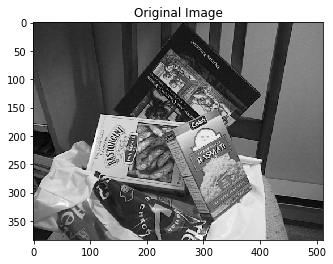

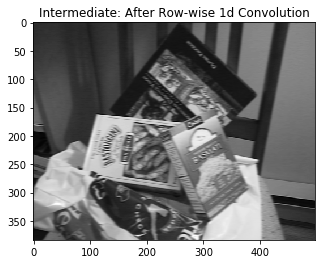

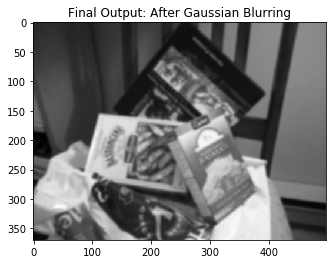

In [2]:
img1 = 'assignment1/scene.pgm'
gaussian_blur(np_from_img(img1), 15)

# Image Alignment<a id='part_2'></a>

In this part of the assignment you will write a function that takes two images as input and computes the affine transformation between them. The overall scheme, as outlined in lecture 5 and 6, is as follows:

* Find local image regions in each image
* Characterize the local appearance of the regions
* Get set of putative matches between region descriptors in each image
* Perform RANSAC to discover best transformation between images

The first two stages can be performed using David Lowe’s SIFT feature detector and descriptor representation. A Matlab implementation of this can be in found in the VLFeat package (http://www.vlfeat.org/overview/sift.html). A Python version can be found in the OpenCV-Python environment (http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html). The two images you should match are contained in the assignment1.zip file: scene.pgm and book.pgm, henceforth called image 1 and 2 respectively. You should first run the SIFT detector over both images to produce a set
of regions, characterized by a 128d descriptor vector. Display these regions on each picture to ensure that a satsifactory number of them have been extracted. Please include the images in your report. 

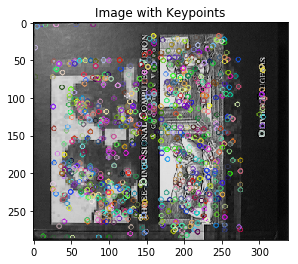

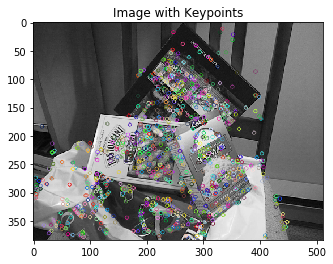

In [3]:
import cv2
import numpy as np

image1 = cv2.imread('assignment1/book.pgm')  # queryImage
image2 = cv2.imread('assignment1/scene.pgm') # trainImage

def sift_detect(img):
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)

    cv2.drawKeypoints(gray,kp,img,) #flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.title("Image with Keypoints")
    plt.show()
    return gray, kp, des


# find the keypoints and descriptors with SIFT    
img1, kp1, des1 = sift_detect(image1)
img2, kp2, des2 = sift_detect(image2)

The next step is to obtain a set of putative matches T. This should be done as follows: for each descriptor in image 1, compute the closest neighbor amongst the descriptors from image 2 using Euclidean distance. Spurious matches can be removed by then computing the ratio of distances between the closest and second-closest neighbor and rejecting any matches that are above a certain threshold. To test the functioning of RANSAC, we want to have some erroneous matches in our set, thus this threshold should be set to a fairly slack value of 0.9. To check that your code is functioning correctly, plot out the two images side-by-side with lines showing the potential matches
(include this in your report).

Number of matches: 244


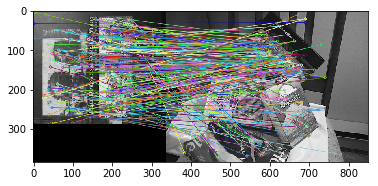

(<matplotlib.image.AxesImage at 0x107389668>, None)

In [4]:
threshold = 0.9

# BFMatcher - taking Eucledian distance
bf = cv2.BFMatcher(cv2.NORM_L2)

# Getting the 2 closest neigbhors
matches = bf.knnMatch(queryDescriptors=des1,trainDescriptors=des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < threshold*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,0,flags=2)
print("Number of matches:",len(good))
plt.imshow(img3),plt.show()

The final stage, running RANSAC, should be performed as follows:

* Repeat N times (where N is ∼100):
* Pick P matches at random from the total set of matches T. Since we are solving for an affine transformation which has 6 degrees of freedom, we only need to select P=3 matches.
* Construct a matrix A and vector b using the 3 pairs of points as described
 in lecture 6.
* Solve for the unknown transformation parameters q. In Matlab you can use the \ command. In Python you can use linalg.solve.
* Using the transformation parameters, transform the locations of all T points in image 1. If the transformation is correct, they should lie close to their pairs in image 2.
* Count the number of inliers, inliers being defined as the number of transformed points from image 1 that lie within a radius of 10 pixels of their pair in image 2.
* If this count exceeds the best total so far, save the transformation parameters and the set of inliers.
* End repeat.

In [5]:
import random

best_count = 0
best_inliers = set()
best_x = 0

for i in range(100):
    p = 3
    m = random.sample(good,p)
    
    q1 = kp1[m[0][0].queryIdx]
    q2 = kp1[m[1][0].queryIdx]
    q3 = kp1[m[2][0].queryIdx]
    
    t1 = kp2[m[0][0].trainIdx]
    t2 = kp2[m[1][0].trainIdx]
    t3 = kp2[m[2][0].trainIdx]
    
    
#   matrix A for transformation
    A = np.array([
                 [*q1.pt, 1, 0, 0, 0 ],
                 [0, 0, 0, *q1.pt, 1],
                 [*q2.pt, 1, 0, 0, 0 ],
                 [0, 0, 0, *q2.pt, 1],
                 [*q3.pt, 1, 0, 0, 0 ],
                 [0, 0, 0, *q3.pt, 1],
                 ])
#   vector b
    b = np.array([*t1.pt, *t2.pt, *t3.pt])
      
    x = np.linalg.solve(A, b)
    
    count = 0
    inliers = set()
    for [m] in good:
        transformed = [[*kp1[m.queryIdx].pt, 1, 0, 0, 0],[0, 0, 0, *kp1[m.queryIdx].pt, 1]] @ x
        
        if np.linalg.norm(transformed - kp2[m.trainIdx].pt) < 10:
            count +=1
            inliers.add(m)
    
    if count > best_count:
        best_count = count
        best_inliers = inliers
        best_x = x

print("Best number of inliers: ",  best_count)

Best number of inliers:  114


* Perform a final refit using the set of inliers belonging to the best transformation you found.  This refit should use all inliers, not just 3 points chosen at random.

In [6]:
A = np.zeros((best_count*2, 6))
b = np.zeros(best_count*2)
best_inliers = list(best_inliers)

for i in range(count):
    A[2*i,0:2] = kp1[best_inliers[i].queryIdx].pt
    A[2*i,2] = 1
    A[2*i + 1,3:5] = kp1[best_inliers[i].queryIdx].pt
    A[2*i + 1,5] = 1
    b[2*i:2*i + 2] = kp2[best_inliers[i].trainIdx].pt

bestq = np.linalg.lstsq(A, b)

## Homography matrix H

In [7]:
bestq[0].reshape(2,3) # Homography matrix H - 2x3

array([[   0.40113177,    0.45658548,  134.63230682],
       [  -0.46778791,    0.42055961,  157.9793555 ]])

## Transformed Image

* Finally, transform image 1 using this final set of transformation parameters, q. In Matlab this can be done by first forming a homography matrix H = [ q(1) q(2) q(5) ; q(3) q(4) q(6) ; 0 0 1 ]; and then using the imtransform and maketform functions as follows: transformed image=imtransform(im1,maketform(’affine’,H’));. In Python you can use the cv2.warpAffine from the OpenCV-Python environment. If you display this image you should find that the pose of the book in the scene should correspond to its pose in image 2. Your report should include: (i) the transformed image 1 and (ii) the values in the matrix H.

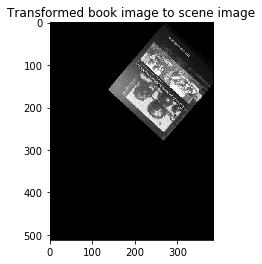

In [8]:
t_img = cv2.warpAffine(img1, bestq[0].reshape(2,3), img2.shape)
plt.imshow(t_img, cmap='gray')
plt.title("Transformed book image to scene image")
plt.show()

# Estimating the Camera Parameters<a id='part_3'></a>

Here the goal is the compute the 3x4 camera matrix P describing a pinhole
camera given the coordinates of 10 world points and their corresponding
image projections. Then you will decompose P into the intrinsic and extrinsic
parameters. You should write a simple Matlab or Python script that works
through the stages below, printing out the important terms.
Download from the course webpage the two ASCII files, world.txt and
image.txt. The first file contains the (X,Y,Z) values of 10 world points. The
second file contains the (x,y) projections of those 10 points.

In [9]:
X = np.array([list(map(float,line.split())) for line in open('assignment1/world.txt')]).reshape(-1, 3)
x = np.array([list(map(float,line.split())) for line in open('assignment1/image.txt')]).reshape(-1, 2)

**(a)** Find the 3x4 matrix $P$ that projects the world points **X** to the 10
image points **x**. This should be done in the following steps:

* Since $P$ is a homogeneous matrix, the world and image points (which are 3 and 2-D respectively), need to be converted into homogeneous points by concatenating a 1 to each of them (thus becoming 4 and 3-D respectively).

In [10]:
temp = np.ones((X.shape[0],X.shape[1] +1))
temp[:,:-1] = X
X = temp.copy()

temp = np.ones((x.shape[0],x.shape[1] +1))
temp[:,:-1] = x
x = temp.copy()

print("Shapes of X and x : ", X.shape,x.shape)

Shapes of X and x :  (10, 4) (10, 3)


* We now note that $\mathbf{x} \times P\mathbf{X} = 0$, irrespective of the scale ambiguity. This allows us to setup a series of linear equations of the form:

$$
\begin{bmatrix}
    O^T & -w_i\mathbf{X}_{i}^T & y_i\mathbf{X}_{i}^T \\
    w_i\mathbf{X}_{i}^T & O^T & -x_i\mathbf{X}_{i}^T \\
    -y_i\mathbf{X}_{i}^T & x_i\mathbf{X}_{i}^T & O^T
\end{bmatrix}
\quad
\begin{pmatrix}
    P^1 \\
    P^2 \\
    P^3
\end{pmatrix}
= 0
$$

for each correspondence $\mathbf{x}_i \leftrightarrow \mathbf{X}_i$, where $\mathbf{x}_i = (x_i, y_i, w_i)^T$, $w_i$ being the homogeneous coordinate, and $P^j$ is the $j^{th}$ row of $P$. But since the 3rd row is a linear combination of the first two, we need only consider the first two rows for each correspondence $i$. Thus, you should form a 20
by 12 matrix $A$, each of the 10 correspondences contributing two rows. This yields $Ap = 0$, $p$ being the vector containing the entries of matrix $P$.

In [11]:
A = np.zeros((20,12))

for i in range(10):
    A[i,4:8] = -x[i,2] *X[i]
    A[i,8:] = x[i,1] *X[i]
    A[10 + i,:4] = x[i,2] *X[i]
    A[10 + i,8:] = -x[i,0] *X[i]

* To solve for $p$, we need to impose an extra constraint to avoid the trivial solution $p = 0$. One simple one is to use ${\left\lVert p \right\rVert}_2 = 1$. This constraint is implicitly imposed when we compute the SVD of $A$. The value of $p$ that minimizes $Ap$ subject to ${\left\lVert p \right\rVert}_2 = 1$ is given by the eigenvector corresponding to the smallest singular value of A. To find this, compute the SVD of $A$, picking this eigenvector and reshaping it into a 3 by 4 matrix $P$.

In [12]:
U, s, V = np.linalg.svd(A)
P = V[-1].reshape(3,4)

print("Ap = ", A@P.flatten())
print("\n Which we can see tends to 0 vector.")

Ap =  [ 0.0031165   0.00914599 -0.00084494  0.00613655 -0.00051187 -0.00967091
  0.00693031 -0.00115237 -0.00409338 -0.00853973  0.01622349 -0.00606993
 -0.00214993 -0.01268336  0.02551535  0.00067579 -0.01688447 -0.01502145
  0.01937915 -0.00956261]

 Which we can see tends to 0 vector.


* Verify your answer by re-projecting the world points $\mathbf{X}$ and checking that they are close to $\mathbf{x}$.

In [13]:
verify = X @ P.transpose()
verify = verify/verify[:,-1][:,None] 
x - verify

array([[-1.1945627 ,  0.2294732 ,  0.        ],
       [ 0.64702229,  0.97491459,  0.        ],
       [-0.4922417 ,  0.19345437,  0.        ],
       [ 6.65105315,  3.21795669,  0.        ],
       [ 1.54616579,  0.03101805,  0.        ],
       [-0.12174349, -1.74220257,  0.        ],
       [-1.04482577, -0.42885395,  0.        ],
       [-7.60834621,  0.58367329,  0.        ],
       [-1.34651196, -0.2844181 ,  0.        ],
       [ 0.97649216, -0.87203986,  0.        ]])

**(b)** Now we have P, we can compute the world coordinates of the projection
center of the camera C. Note that PC = 0, thus C lies in the null
space of P, which can again be found with an SVD (the Matlab command
is svd). Compute the SVD of P and pick the vector corresponding to this
null-space. Finally, convert it back to inhomogeneous coordinates and to
yield the (X,Y,Z) coordinates. Your report should contain the matrix P and
the value of C.

In [14]:
U, s, V = np.linalg.svd(P)

# Picking the last row (eignevector are rows in v according to the numpy docs) 
# corresposnding to the smallest singular value and then converting to the 
# inhomogenous form of C by dividing by the last element.

C = (V[-1]/V[-1,-1])[:-1]
print("Matrix P: ",P)
print("Inhomogenized C: ",C)

Matrix P:  [[-0.31271962  0.6586667   0.26909429 -0.23501562]
 [-0.1662223   0.46566253  0.20039419 -0.20987749]
 [-0.03970363  0.08943154  0.03723786 -0.03288861]]
Inhomogenized C:  [  1.97567787e-16   3.89749895e-16  -6.37064392e-16]


In the alternative route, we decompose P into it’s constituent matrices. Recall from the lectures that P = K[R|t]. However, also, $t = −R\tilde{C}$, $\tilde{C}$ being the inhomogeneous form of C. Since K is upper triangular, use a RQdecomposition to factor $KR$ into the intrinsic parameters K and a rotation matrix
R. Then solve for $\tilde{C}$. Check that your answer agrees with the solution from
the first method.

In [15]:
from scipy import linalg
r, Q = linalg.rq(P)
t = Q[:,-1]
R = Q[:,:-1]

# LU = linalg.lu_factor(-R)
# C = linalg.lu_solve(LU, t)
# C = np.linalg.solve(-R, t)
C, _, _ ,_ = np.linalg.lstsq(-R, t)
print("Inhomogenized C found using RQ-decompostion: ",C)

Inhomogenized C found using RQ-decompostion:  [  1.38777878e-16   3.33066907e-16   0.00000000e+00]


# Structure from Motion<a id='part_4'></a>
In this section you will code up an affine structure from motion algorithm,
as described in the slides of lecture 6. For more details, you can consult page
437 of the Hartley & Zisserman book.
Load the file sfm points.mat (included in assignment1.zip). In Python
this can be done using scipy (http://docs.scipy.org/doc/scipy/reference/tutorial/io.html).The file contains a 2 by 600 by 10 matrix, holding
the x, y coordinates of 600 world points projected onto the image plane
of the camera in 10 different locations. The points correspond, that is
image points(:,1,:) is the projection of the same 3D world point in the
10 frames. The points have been drawn randomly to lie on the surface of a
transparent 3D cube, which does not move between frames (i.e. the object is
static, only the camera moves). Try plotting out several frames and the cube
shaped structure should be apparent (the plot3 command may be useful).


In [16]:
import scipy.io as sio
img_pt =sio.loadmat('assignment1/sfm_points.mat')['image_points']
print("Shape of image_point matrix: ",img_pt.shape)

Shape of image_point matrix:  (2, 600, 10)


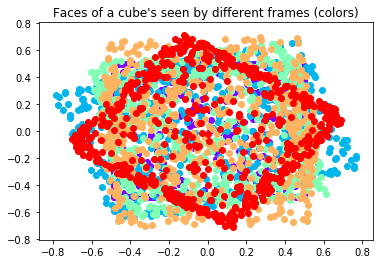

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

_, n, m = img_pt.shape
colors = iter(cm.rainbow(np.linspace(0, 1, m//2)))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

for i in range(0, m, 2):
    plt.scatter(*img_pt[:,:,i], c=next(colors))
plt.title("Faces of a cube's seen by different frames (colors)")

To simplify matters, we will only attempt an affine reconstruction, thus the projection matrix of each camera $i$ will have following form:
$$
P^i =
\begin{pmatrix}
p_{11} & p_{12} & p_{13} & p_{14}\\
p_{21} & p_{22} & p_{23} & p_{24}\\
0 & 0 & 0 & 1 \\
\end{pmatrix}
=
\begin{pmatrix}
M^i & t^i \\
0 & 1
\end{pmatrix}
\quad
$$

where $M^i$ is a 2 by 3 matrix and $t^i$ is a 2 by 1 translation vector.
   
So given $m = 10$ views and $n = 600$ points, having image locations $\mathbf{x}_i^j$, where $j = 1, . . . , n, i = 1, . . . , m$, we want to determine the affine camera matrices $M^i$, $t^i$ and 3D points $\mathbf{X}_j$ so that we minimize the reconstruction error:
$$
\sum_{ij}{} \left\lVert \mathbf{x}_i^j - (M^i \mathbf{X}_j + t^i) \right\rVert^2
$$

We do this in the following stages:

* Compute the translations $t^i$ directly by computing the centroid of point in each image $i$.
* Center the points in each image by subtracting off the centroid, so that the points have zero mean

In [18]:
t = np.zeros((m,2))
for i in range(m):
    t[i] = np.mean(img_pt[0,:,i]), np.mean(img_pt[1,:,i])
    img_pt[:,:,i] -= t[i][:,None] 

* Construct the 2m by n measurement matrix W from the centered data.

In [19]:
W = np.zeros((2*m, n))
for i in range(n):
    W[::2,i] = img_pt[0,i,:]
    W[1::2,i] = img_pt[1,i,:]

* Perform an SVD decomposition of $W$ into $UDV^T$.

In [20]:
U, s, V = np.linalg.svd(W)

* The camera locations $M^i$ can be obtained from the first three columns of $U$ multiplied by $D(1 : 3, 1 : 3)$, the first three singular values.

In [21]:
M = U[:,:3] @ np.diag(s[:3])

* The 3D world point locations are the first three columns (rows for numpy) of V .

In [22]:
world_pt = V[:3]

* You can verify your answer by plotting the 3D world points out. using the plot3 command. The rotate3d command will let you rotate the plot. This functionality is replicated in Python within the matplotlib package.

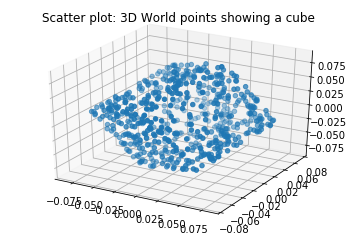

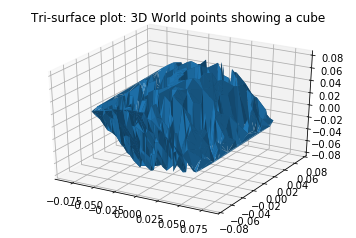

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

_, n, m = img_pt.shape
colors = iter(cm.rainbow(np.linspace(0, 1, m//2)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*world_pt)
ax.set_title("Scatter plot: 3D World points showing a cube")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(*world_pt)
ax.set_title("Tri-surface plot: 3D World points showing a cube")

You should write a script to implement the steps above. The script should print out the $M^i$ and $t^i$
for the first camera and also the 3D coordinates of the first 10 world points. Cut and paste these into your report.

In [24]:
def first_camera(img_pt):
    ''' return: (M^0, t^0, np.array(first 10 world points))
    '''
    
    # t^i construction
    t = np.zeros((m,2))
    for i in range(m):
        t[i] = np.mean(img_pt[0,:,i]), np.mean(img_pt[1,:,i])
        img_pt[:,:,i] -= t[i][:,None] 

    # W matrix of 2m by n construction
    W = np.zeros((2*m, n))
    for i in range(n):
        W[::2,i] = img_pt[0,i,:]
        W[1::2,i] = img_pt[1,i,:]

    # M^i construction
    U, s, V = np.linalg.svd(W)
    M = U[:,:3] @ np.diag(s[:3])
    
    # World Points
    world_pt = V[:3]
    
    return (M[:2], t[0], world_pt[:,:10])

## First Camera and First World Points

$M^i$ and $t^i$ of the first camera and the first 10 world points respectively are as follows:

In [25]:
img_pts = sio.loadmat('assignment1/sfm_points.mat')['image_points']

print('''M^i of the first camera:\n {}\n 
t^i of the first camera:\n {}\n
First 10 world points: \n {}'''.format(*first_camera(img_pts)))

M^i of the first camera:
 [[-7.50914219  3.30837904 -3.71763726]
 [-4.53754376 -1.57773527  7.74574759]]
 
t^i of the first camera:
 [  2.36847579e-17   8.28966525e-17]

First 10 world points: 
 [[ 0.00577163  0.0005761  -0.04293585  0.04745038 -0.04210186  0.05961964
   0.00909167  0.01039489 -0.02589081  0.01745598]
 [ 0.06460628  0.06885363  0.06330479  0.04904207  0.06789239  0.0460518
   0.06002049  0.04602065  0.05702972  0.04054264]
 [-0.02497615 -0.03458151  0.02861711 -0.01257547  0.01175164 -0.01438374
  -0.01229997  0.03529275  0.03337375  0.04731859]]
